In [1]:
import warnings

import eli5

warnings.filterwarnings("ignore")

/home/balde/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
## Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("ggplot")
%matplotlib inline

import catboost as cb
import plotly.express as px
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

## Reading the data

In [3]:
train = pd.read_csv("Train.csv")

test = pd.read_csv("Test.csv")
sub = pd.read_csv("SampleSubmission (1).csv")
vard = pd.read_csv("VariableDescription.csv")

## Exploratory Data Analysis

In [4]:
df_train = train.copy()
df_test = test.copy()

# Machine Learning Algorithms

In [5]:
train_int_cols = train.select_dtypes(
    include=["float64", "number", "Int64", "int64"]
).columns
test_int_cols = test.select_dtypes(
    include=["float64", "number", "Int64", "int64"]
).columns

# Numerical columns
num_cols = list(set(test_int_cols).intersection(set(train_int_cols)))

In [6]:
X = train[num_cols]
y = train.target

In [7]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=55)

# Cross validation
def cross_validation(X, y, model, cv):
    rmse_scores = list()
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fitting the model to the data
        model.fit(X_train, y_train)

        # Prediction Probabilities
        preds = model.predict(X_test)

        rmse_scores.append(mean_squared_error(y_test, preds, squared=False))

    avg_rmse = np.mean(rmse_scores)
    return avg_rmse, rmse_scores

## Lightgbm

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=55
)

In [10]:
lgbm = LGBMRegressor(
    objective="tweedie",
    learning_rate=0.01,
    n_estimators=3000,
    num_leaves=35,
    max_bin=240,
    max_depth=9,
    min_child_samples=20,
    random_state=42,
)

lgbm.fit(X_train, y_train)

# Make predictions
y_pred = lgbm.predict(X_test)

# Check score
mean_squared_error(y_test, y_pred, squared=False)

9.974071920126116

In [11]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

rmse, cv_scores = cross_validation(X, y, lgbm, k_fold)
print(f"avg_score: {rmse}, \nrmse_scores: {cv_scores}")

avg_score: 10.071592226376595, 
rmse_scores: [9.986168633503029, 10.319066233711798, 10.01040308892078, 9.889022779477946, 10.153300396269419]


In [12]:
from lightgbm import plot_importance

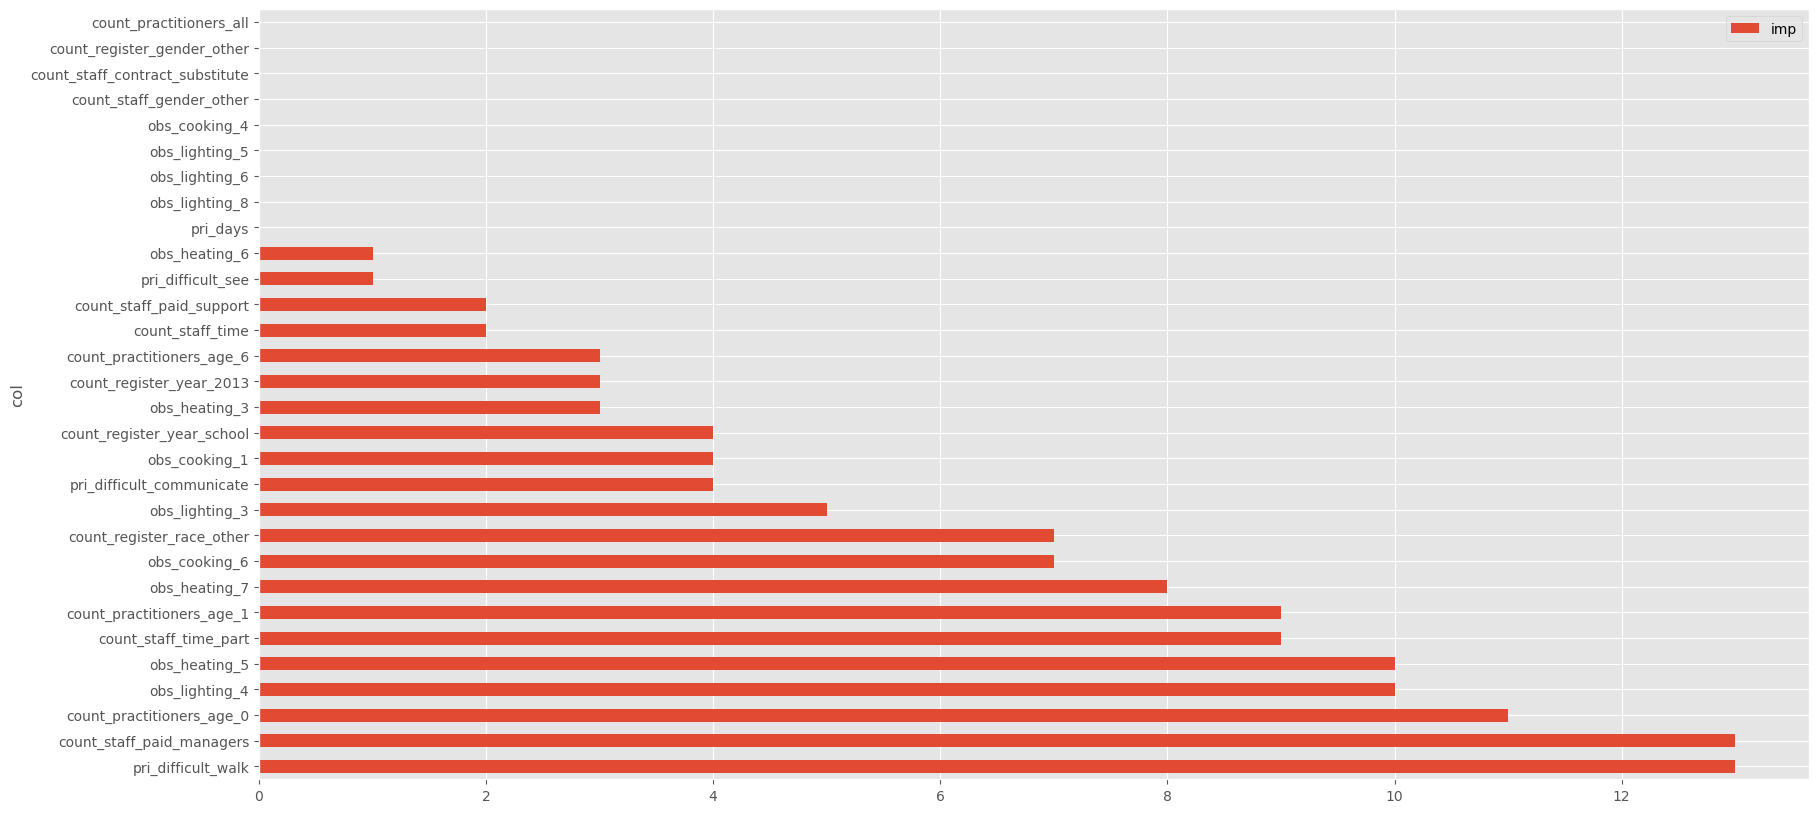

In [14]:
# plot_importance(lgbm, max_num_features=50, height=30)
fea_imp = pd.DataFrame({"imp": lgbm.feature_importances_, "col": X.columns})
fea_imp = fea_imp.sort_values(["imp", "col"], ascending=False).iloc[-30:]
_ = fea_imp.plot(kind="barh", x="col", y="imp", figsize=(20, 10))
plt.savefig("catboost_feature_importance.png")

In [15]:
feature_imp = lgbm.feature_importances_
feature_imp[feature_imp < 5]

array([0, 4, 0, 1, 2, 0, 0, 0, 3, 0, 0, 2, 3, 0, 4, 0, 3, 4, 1],
      dtype=int32)

In [16]:
low_imp_col = list()
for col, imp in list(zip(num_cols, feature_imp)):
    if imp <= 5:
        print(f"{col}: {imp}")
        low_imp_col.append(col)

pri_days: 0
obs_cooking_1: 4
obs_cooking_4: 0
pri_difficult_see: 1
count_staff_time: 2
count_register_gender_other: 0
obs_lighting_8: 0
obs_lighting_5: 0
count_register_year_2013: 3
count_staff_gender_other: 0
obs_lighting_6: 0
count_staff_paid_support: 2
count_practitioners_age_6: 3
count_practitioners_all: 0
pri_difficult_communicate: 4
count_staff_contract_substitute: 0
obs_heating_3: 3
count_register_year_school: 4
obs_lighting_3: 5
obs_heating_6: 1


In [17]:
# Creating dataset using important columns from lgbm.feature_imp

X = train[num_cols].drop(columns=low_imp_col)
X.shape

(8585, 139)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

## Lgbm

In [27]:
params = {
    # "objective": "tweedie",
    "learning_rate": 0.01,
    "objective": "regression",
    "n_estimators": 3000,
    "num_leaves": 35,
    "max_bin": 240,
    "colsample_bytree": 0.7,
    "max_depth": 9,
    "min_child_samples": 20,
    "random_state": 42,
}

In [20]:
lgbm = LGBMRegressor(**params)

lgbm.fit(X_train, y_train)

# Make predictions
y_pred = lgbm.predict(X_test)

# Check score
mean_squared_error(y_test, y_pred, squared=False)

9.732839131750122

In [21]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=55)

rmse, cv_scores = cross_validation(X, y, lgbm, k_fold)
print(f"avg_score: {rmse}, \nrmse_scores: {cv_scores}")

avg_score: 9.804005590476757, 
rmse_scores: [9.785257021601735, 9.759459194945732, 9.880795202221755, 9.486110508436287, 10.166063626752644, 9.785609549034838, 9.405680936408881, 10.37823042434041, 9.938635864428253, 9.45421357659703]


In [22]:
lgbm = LGBMRegressor(**params)

lgbm.fit(X, y)

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.01, max_bin=240,
              max_depth=9, n_estimators=3000, num_leaves=35,
              objective='regression', random_state=42)

In [23]:
test_data = test[num_cols].drop(columns=low_imp_col, axis=1)
lgbm_preds_new_feat = lgbm.predict(test_data)
lgbm_preds_new_feat

array([60.9588549 , 46.74794213, 49.03987776, ..., 40.64460699,
       44.53313766, 43.35602411])

## Making Submission filr

In [24]:
import eli5

In [25]:
test_data = test[num_cols].drop(columns=low_imp_col, axis=1)

In [26]:
sub_file = pd.read_csv("GBRSubmission1_score_10.63.csv")
sub_file.target = lgbm_preds_new_feat
sub_file.to_csv("lgb.csv", index=False)